In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn import model_selection
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
import geopandas as gpd
import random
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

matplotlib.rcParams['figure.figsize'] = (10, 5)
matplotlib.rcParams['font.size'] = 15
random.seed(0)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

## Data Gathering

In [2]:
# Import data
df_calendar = pd.read_csv('Data/calendar.csv', parse_dates=['date'])
df_listings = pd.read_csv('Data/listings.csv')
#df_neighbourhoods = pd.read_csv('Data/neighbourhoods.csv')

## Data Cleaning

#### Calendar Cleaning
- Remove all missing value
- Remove $ from price and adjusted_price
- Create a statistics for occupancy ratio for each listing_id

In [4]:
# Check data
df_calendar.head(10)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,109,2021-12-06,f,$115.00,$115.00,30.0,730.0
1,26082,2021-12-07,t,$89.00,$89.00,30.0,60.0
2,26082,2021-12-08,t,$89.00,$89.00,30.0,60.0
3,26082,2021-12-09,t,$89.00,$89.00,30.0,60.0
4,26082,2021-12-10,t,$89.00,$89.00,30.0,60.0
5,26082,2021-12-11,t,$89.00,$89.00,30.0,60.0
6,26082,2021-12-12,t,$89.00,$89.00,30.0,60.0
7,26082,2021-12-13,t,$89.00,$89.00,30.0,60.0
8,26082,2021-12-14,t,$89.00,$89.00,30.0,60.0
9,26082,2021-12-15,t,$89.00,$89.00,30.0,60.0


In [5]:
# Remove na
df_calendar = df_calendar.dropna()
#df_calendar.isnull().sum()

In [6]:
# Remove $ from price and adjusted_price
df_calendar["price"] = df_calendar["price"].apply(lambda x: float(x.replace(',','')[1:]))
df_calendar["adjusted_price"] = df_calendar["adjusted_price"].apply(lambda x: float(x.replace(',','')[1:]))

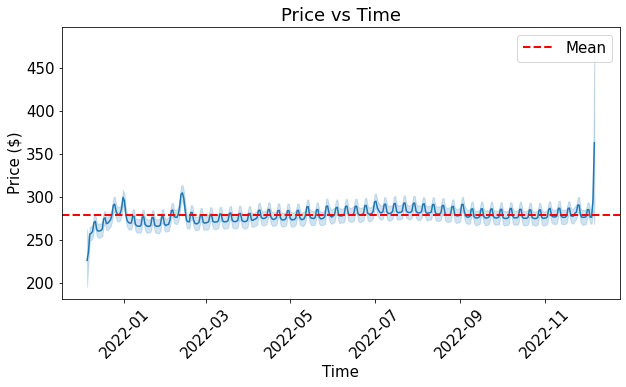

In [ ]:
ax = sns.lineplot(x = "date", y = "price", markers = True, dashes = False, data = df_calendar)
plt.axhline(df_calendar['price'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.xticks(rotation = 45)
plt.title('Price vs Time')
plt.xlabel('Time')
plt.ylabel('Price ($)')
plt.legend(loc='best')

- The average price is around 280.
- The price is steady over the year.

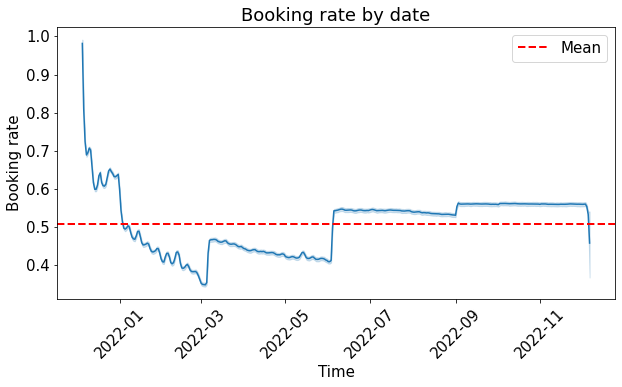

In [7]:
# Define available as 1 if 't'; o.w. 0.
df_calendar['available'] = df_calendar['available'].map({'t':0, 'f':1})

# Plot 
ax = sns.lineplot(x = "date", y = "available", markers = True, dashes = False, data = df_calendar)
plt.axhline(df_calendar['available'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
plt.xticks(rotation = 45)
plt.title('Booking rate by date')
plt.xlabel('Time')
plt.ylabel('Booking rate')
plt.legend(loc='best')

- Booking rate increase by March and June (Summer, etc.)

In [8]:
# Calculate daily revenue
df_calendar['revenue'] = df_calendar['price'] * df_calendar['available']

In [9]:
df_calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,revenue
0,109,2021-12-06,1,115.0,115.0,30.0,730.0,115.0
1,26082,2021-12-07,0,89.0,89.0,30.0,60.0,0.0
2,26082,2021-12-08,0,89.0,89.0,30.0,60.0,0.0
3,26082,2021-12-09,0,89.0,89.0,30.0,60.0,0.0
4,26082,2021-12-10,0,89.0,89.0,30.0,60.0,0.0


In [10]:
# Calculate financial overview of the booking.
occupancy = df_calendar.groupby('listing_id')['available', 'price'].mean()
occupancy.columns = ['occupancy_ratio', 'daily_revenue']

# Average daily revenue
print(np.mean(occupancy['daily_revenue']))

278.757778719889


In [11]:
occupancy.head()

,occupancy_ratio,daily_revenue
listing_id,,
109,0.380822,115.000000
2708,0.104110,89.000000
2732,0.016438,167.000000
2864,1.000000,70.975342
3021,0.156164,117.876712


#### Listing cleaning
- Remove $ from price
- Remove unused columns

In [12]:
df_listings = pd.read_csv('Data/listings.csv')

In [13]:
# Check data
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,109,https://www.airbnb.com/rooms/109,20211205213202,2021-12-06,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...",NaN,https://a0.muscache.com/pictures/4321499/1da98...,521,https://www.airbnb.com/users/show/521,Paolo,2008-06-27,"San Francisco, California, United States","Paolo Privitera, CEO Evensi\n\nPaolo, MIT MBA ...",NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/e704a...,https://a0.muscache.com/im/pictures/user/e704a...,Culver City,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,NaN,Culver City,Other Cities,33.98301,-118.38607,Entire condominium (condo),Entire home/apt,6,NaN,2 baths,2.0,3.0,"[""Free parking on premises"", ""Shampoo"", ""TV wi...",$115.00,30,730,30.0,30.0,730.0,730.0,30.0,730.0,NaN,t,0,0,0,226,2021-12-06,2,0,0,2011-08-15,2016-05-15,4.00,5.00,5.00,3.00,4.00,5.00,4.00,NaN,f,1,1,0,0,0.02
1,2708,https://www.airbnb.com/rooms/2708,20211205213202,2021-12-06,Runyon Canyon | Beau Furn Mirror Mini-Suite Fi...,"Run Runyon Canyon, Our Gym & Sauna Open <br />...","Walk and run to Runyon Canyon, it is open!<br ...",https://a0.muscache.com/pictures/miso/Hosting-...,3008,https://www.airbnb.com/users/show/3008,Chas.,2008-09-16,"Los Angeles, California, United States",Writer.\r\nLiterary Manager.\r\nPhotographer.\...,within a few hours,100%,100%,t,https://a0.muscache.com/im/pictures/user/d17cf...,https://a0.muscache.com/im/pictures/user/d17cf...,Hollywood,2.0,2.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Los Angeles, California, United States",Hollywood,City of Los Angeles,34.09625,-118.34605,Private room in rental unit,Private room,1,NaN,1 shared bath,1.0,1.0,"[""Free parking on premises"", ""Shampoo"", ""Dishe...",$89.00,30,366,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,1,22,52,327,2021-12-06,33,5,0,2017-12-29,2021-11-01,4.82,4.79,4.91,5.00,4.97,5.00,4.85,NaN,t,3,0,3,0,0.69
2,2732,https://www.airbnb.com/rooms/2732,20211205213202,2021-12-06,Zen Life at the Beach,An oasis of tranquility awaits you.<br /><br /...,"This is the best part of Santa Monica. Quiet, ...",https://a0.muscache.com/pictures/1082974/0f74c...,3041,https://www.airbnb.com/users/show/3041,Yoga Priestess,2008-09-17,"Santa Monica, California, United States",I have been teaching yoga and meditation for 3...,within an hour,100%,37%,t,https://a0.muscache.com/im/users/3041/profile_...,https://a0.muscache.com/im/users/3041/profile_...,Santa Monica,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Santa Monica, California, United States",Santa Monica,Other Cities,34.00440,-118.48095,Private room in rental unit,Private room,1,NaN,1 private bath,1.0,1.0,"[""Washer"", ""He

In [14]:
# Remove $ from price
df_listings["price"] = df_listings["price"].apply(lambda x: float(x.replace(',','')[1:]))

# Host is superhost, 1 if 't', 0 if 'f'
df_listings['host_is_superhost'] = df_listings['host_is_superhost'].map({'t':1, 'f':0})

# Get the number of bathrooms from the bathrooms_text
df_listings['bathrooms'] = df_listings["bathrooms_text"].str.extract("(\d*\.?\d+)", expand=True).astype(float)

# Change host_repsonse_rate and host_acceptance_rate from % to fraction
df_listings['host_response_rate'] = df_listings['host_response_rate'].str.replace("%", "")
df_listings['host_response_rate'] = df_listings['host_response_rate'].fillna(0).astype(float) / 100

df_listings['host_acceptance_rate'] = df_listings['host_acceptance_rate'].str.replace("%", "")
df_listings['host_acceptance_rate'] = df_listings['host_acceptance_rate'].fillna(0).astype(float) / 100

In [15]:
# Short term rental
df_listings = df_listings[df_listings["minimum_minimum_nights"] < 20]

In [16]:
# Keep useful columns
df_listings = df_listings[['id', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'longitude', 'latitude', 'room_type', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'minimum_nights', 'maximum_nights', 'price', 'number_of_reviews', 'review_scores_rating','review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']]

In [17]:
# Combine datasets.
df = pd.merge(df_listings, occupancy, how='left', left_on='id', right_on='listing_id')
df.head()

,id,host_response_rate,host_acceptance_rate,host_is_superhost,neighbourhood_cleansed,neighbourhood_group_cleansed,longitude,latitude,room_type,accommodates,bedrooms,beds,bathrooms,minimum_nights,maximum_nights,price,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,occupancy_ratio,daily_revenue
0,2732,1.0,0.37,1.0,Santa Monica,Other Cities,-118.48095,34.00440,Private room,1,1.0,1.0,1.0,7,27,167.0,21,4.68,4.45,4.57,4.65,4.70,4.90,4.40,0.016438,167.000000
1,7992,1.0,0.83,1.0,Atwater Village,City of Los Angeles,-118.26068,34.11364,Entire home/apt,4,1.0,2.0,1.0,1,1125,117.0,253,4.94,4.94,4.92,4.98,4.97,4.94,4.89,0.616438,142.536986
2,11374,0.0,0.00,0.0,Gardena,Other Cities,-118.29217,33.90507,Private room,2,1.0,1.0,1.0,1,7,88.0,59,4.41,4.61,4.44,4.73,4.61,4.24,4.39,0.019178,87.506849
3,13776,1.0,0.97,1.0,Redondo Beach,Other Cities,-118.38638,33.83931,Entire home/apt,4,1.0,1.0,1.0,2,1125,153.0,201,4.81,4.87,4.79,4.86,4.87,4.87,4.73,0.161644,175.956164
4,14098,1.0,0.82,1.0,Hollywood Hills,City of Los Angeles,-118.31997,34.11834,Entire home/apt,2,1.0,1.0,1.0,5,365,312.0,33,4.97,4.95,4.95,5.00,5.00,4.95,4.79,0.915068,309.561644


In [18]:
# Checking missing value
df.isnull().sum()

id                                 0
host_response_rate                 0
host_acceptance_rate               0
host_is_superhost                  3
neighbourhood_cleansed             0
neighbourhood_group_cleansed       0
longitude                          0
latitude                           0
room_type                          0
accommodates                       0
bedrooms                        1371
beds                             697
bathrooms                         81
minimum_nights                     0
maximum_nights                     0
price                              0
number_of_reviews                  0
review_scores_rating            2168
review_scores_accuracy          2284
review_scores_cleanliness       2284
review_scores_checkin           2287
review_scores_communication     2285
review_scores_location          2288
review_scores_value             2289
occupancy_ratio                    0
daily_revenue                      0
dtype: int64

In [19]:
# Remove NA from beds and bedrooms for now, could change to mean or median in the future.
df = df.dropna()

<Figure size 720x1440 with 0 Axes>

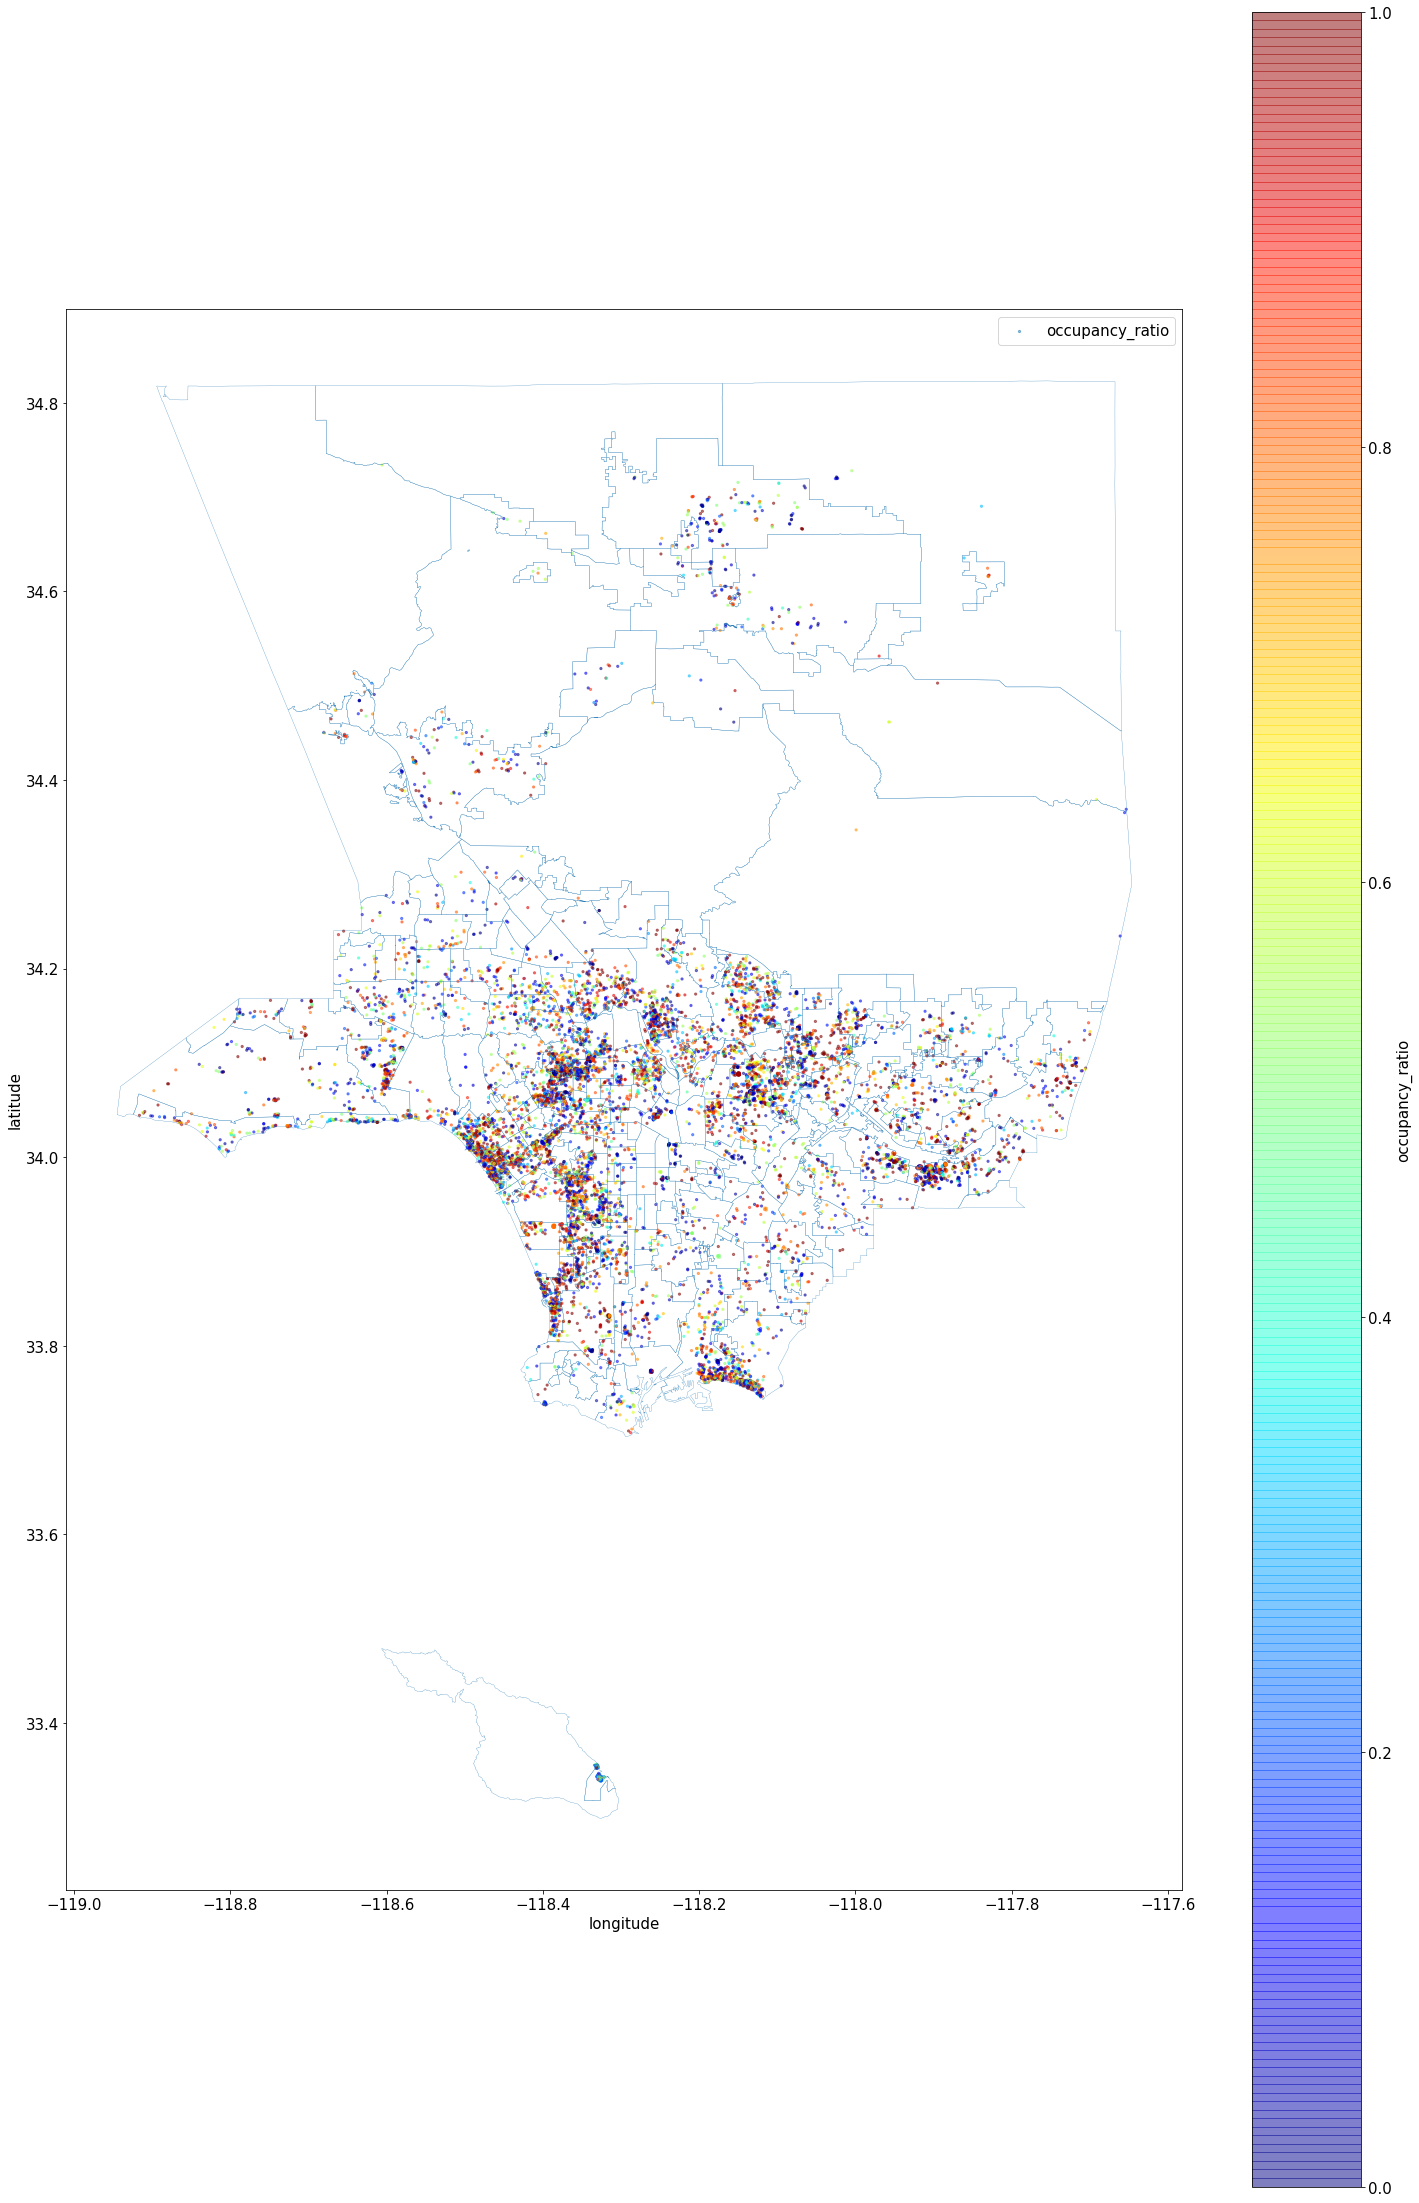

In [23]:
# Plot occupancy_ratio rate of Los Angeles
#la_map = gpd.read_file('Data/neighbourhoods.geojson')
la_map = gpd.read_file('neighbourhoods.geojson')

plt.figure(figsize=(10,20))
ax = la_map.boundary.plot(linewidth = 0.25)
ax.set_facecolor("white")
df.plot(kind='scatter', x='longitude', y='latitude', label='occupancy_ratio', c='occupancy_ratio',
                  cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.5, s=  5, figsize=(25,40), ax=ax)

plt.legend()
plt.show()

In [24]:
# Remove outliers
def outliers(df, column, num_dev=4):
    q25, q75 = df[column].quantile(q=[0.25, 0.75])
    iqr = q75 - q25
    max_n = q75 + num_dev * iqr
    # identify the points
    outlier_mask = [True if x > max_n else False for x in df[column]]
    print('{} outliers found out of {} data points, {}% of the data. {} is the max'.format(
        sum(outlier_mask), len(df[column]),
        100 * (sum(outlier_mask) / len(df[column])),max_n))
    return outlier_mask

df['outliers'] = outliers(df, 'bedrooms')
df = df[df['outliers'] == False]

df['outliers'] = outliers(df, 'beds', num_dev = 5)
df = df[df['outliers'] == False]

df['outliers'] = outliers(df, 'bathrooms')
df = df[df['outliers'] == False]

df.drop(labels='outliers', inplace=True, axis=1)

38 outliers found out of 11283 data points, 0.33678986085261015% of the data. 6.0 is the max
2 outliers found out of 11245 data points, 0.01778568252556692% of the data. 13.0 is the max
37 outliers found out of 11243 data points, 0.32909365827626075% of the data. 6.0 is the max


<AxesSubplot:>

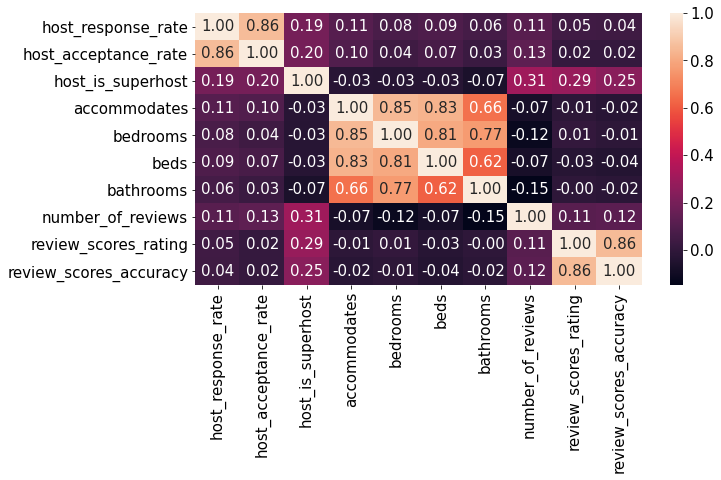

In [49]:
# Correlations
corr_score = df[['host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'number_of_reviews', 'review_scores_rating','review_scores_accuracy']].corr()
sns.heatmap(corr_score, annot=True, fmt=".2f")

## Modeling

#### Occupancy rate

In [25]:
# Get feature
X = df[['host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'neighbourhood_group_cleansed', 'room_type', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating','review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']]
X.dtypes

host_response_rate              float64
host_acceptance_rate            float64
host_is_superhost               float64
neighbourhood_group_cleansed     object
room_type                        object
accommodates                      int64
bedrooms                        float64
beds                            float64
bathrooms                       float64
minimum_nights                    int64
maximum_nights                    int64
number_of_reviews                 int64
review_scores_rating            float64
review_scores_accuracy          float64
review_scores_cleanliness       float64
review_scores_checkin           float64
review_scores_communication     float64
review_scores_location          float64
review_scores_value             float64
dtype: object

In [26]:
y = df['occupancy_ratio']

In [27]:
# One hot encoding
def OneHotEncoding(df, enc, categories):  
  transformed = pd.DataFrame(enc.transform(df[categories]).toarray(), columns=enc.get_feature_names(categories))
  return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(categories, axis=1)

categories = ['neighbourhood_group_cleansed', 'room_type']
enc_ohe = OneHotEncoder()
enc_ohe.fit(X[categories])

X = OneHotEncoding(X, enc_ohe, categories)

In [28]:
X.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,accommodates,bedrooms,beds,bathrooms,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,neighbourhood_group_cleansed_City of Los Angeles,neighbourhood_group_cleansed_Other Cities,neighbourhood_group_cleansed_Unincorporated Areas,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,1.0,0.37,1.0,1,1.0,1.0,1.0,7,27,21,4.68,4.45,4.57,4.65,4.70,4.90,4.40,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.83,1.0,4,1.0,2.0,1.0,1,1125,253,4.94,4.94,4.92,4.98,4.97,4.94,4.89,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.00,0.0,2,1.0,1.0,1.0,1,7,59,4.41,4.61,4.44,4.73,4.61,4.24,4.39,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.97,1.0,4,1.0,1.0,1.0,2,1125,201,4.81,4.87,4.79,4.86,4.87,4.87,4.73,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.82,1.0,2,1.0,1.0,1.0,5,365,33,4.97,4.95,4.95,5.00,5.00,4.95,4.79,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [29]:
# Split dataset (Reserve 25% for testing)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=1)

print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

training data has 8404 observation with 24 features
test data has 2802 observation with 24 features


##### Model development

##### Linear Regression

In [30]:
# Linear Regression
LR = LinearRegression()
LR.fit(X_train, y_train)

LinearRegression()

##### Lasso

In [33]:
from sklearn.linear_model import Lasso
# Grid search to find best lambda
from sklearn.model_selection import GridSearchCV
from numpy import arange

# define penalty parameter
grid = {'alpha':arange(0,1,100)}

Grid_Lasso = GridSearchCV(Lasso(),grid, scoring='neg_mean_absolute_error', cv=10)
results_lasso=Grid_Lasso.fit(X_train,y_train)
# summarize best MSE and best penalty parameter
print('MAE: %.3f' % -results_lasso.best_score_)
print('Config: %s' % results_lasso.best_params_)

MAE: 0.302
Config: {'alpha': 0}


##### Ridge

In [34]:
# Grid search to find best lambda
from sklearn.model_selection import GridSearchCV

# define penalty parameter
grid = {'alpha':arange(0,1,0.01)}

Grid_Ridge = GridSearchCV(Ridge(),grid, scoring='neg_mean_absolute_error', cv=10)
results_Ridge=Grid_Ridge.fit(X_train,y_train)
# summarize best MSE and best penalty parameter
print('MAE: %.3f' % -results_Ridge.best_score_)
print('Config: %s' % results_Ridge.best_params_)

MAE: 0.302
Config: {'alpha': 0.01}


In [35]:
ridge_penalty = Ridge(alpha=0.01)
ridge_penalty.fit(X_train,y_train)

Ridge(alpha=0.01)

##### Random Forest

In [36]:
#random forest regressor
from sklearn.ensemble import RandomForestRegressor
regress_RF = RandomForestRegressor()
regress_RF.fit(X_train, y_train)

RandomForestRegressor()

##### KNN

In [42]:
#KNN regressor
from sklearn.neighbors import KNeighborsRegressor
regress_KNN = KNeighborsRegressor()
regress_KNN.fit(X_train, y_train)

KNeighborsRegressor()

##### Support Vector Regression

In [43]:
from sklearn import svm
regress_SVM = svm.SVR()
regress_SVM.fit(X_train,y_train)

SVR()

##### Bayesian Ridge

In [44]:
from sklearn.linear_model import BayesianRidge
regress_Baye = BayesianRidge()
regress_Baye.fit(X_train,y_train)

BayesianRidge()

##### Model Evaluation

$R^2$

In [45]:
# Use 5-fold Cross Validation to get the accuracy for different models
model_names = ['Linear Regression','Ridge Regression','Random Forest Regressor','K-nearest Neignbor Regressor','Support Vector Regression','Bayesian Ridge']
model_list = [LR,ridge_penalty,regress_RF,regress_KNN,regress_SVM,regress_Baye]
count = 0

for regressor in model_list:
    cv_score = model_selection.cross_val_score(regressor, X_train, y_train, cv=10)
    print(cv_score)
    print('Model R-square of ' + model_names[count] + ' is ' + str(cv_score.mean()))
    print(" ")
    count += 1

[0.09827017 0.11861153 0.10452889 0.13454006 0.12004751 0.13206268
 0.11611815 0.05222003 0.11110899 0.11289499]
Model R-square of Linear Regression is 0.1100403006180463
 
[0.09827027 0.11861195 0.1045293  0.13454008 0.12004778 0.13206256
 0.11611818 0.05222067 0.11110881 0.11289508]
Model R-square of Ridge Regression is 0.11004046856364096
 
[0.17098872 0.19206812 0.18976626 0.1891377  0.20516757 0.20007274
 0.18973562 0.12188153 0.1930797  0.18959002]
Model R-square of Random Forest Regressor is 0.1841487971833477
 
[-0.04499815 -0.02322802 -0.00847744 -0.04335993 -0.00903234 -0.02628606
 -0.03519873 -0.06829809  0.03244697 -0.00150433]
Model R-square of K-nearest Neignbor Regressor is -0.022793611012448377
 
[-3.14555047e-02 -2.59911805e-03  8.34800591e-02 -3.70426589e-03
  5.37133565e-02  3.20041555e-05  7.59679939e-03 -3.87545934e-02
  7.05697546e-03  5.76898132e-02]
Model R-square of Support Vector Regression is 0.01330555257465511
 
[0.09817586 0.11966931 0.10567396 0.13413824 

Mean Squared Error

In [46]:
# Use 5-fold Cross Validation to get the accuracy for different models
model_names = ['Linear Regression','Ridge Regression','Random Forest Regressor','K-nearest Neignbor Regressor','Support Vector Regression','Bayesian Ridge']
model_list = [LR,ridge_penalty,regress_RF,regress_KNN,regress_SVM,regress_Baye]
count = 0

for regressor in model_list:
    cv_score = model_selection.cross_val_score(regressor, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
    print(cv_score)
    print('Model mean squared error of ' + model_names[count] + ' is ' + str(-cv_score.mean()))
    print(" ")
    count += 1

[-0.11797533 -0.11373737 -0.11796307 -0.11432047 -0.11558756 -0.11160788
 -0.12229938 -0.11998806 -0.11783608 -0.11770265]
Model mean squared error of Linear Regression is 0.1169017845268742
 
[-0.11797532 -0.11373732 -0.11796302 -0.11432046 -0.11558753 -0.1116079
 -0.12229937 -0.11998798 -0.1178361  -0.11770264]
Model mean squared error of Ridge Regression is 0.11690176280587501
 
[-0.10734131 -0.10402371 -0.10504799 -0.10812373 -0.10522673 -0.10372084
 -0.11063115 -0.11216667 -0.10578529 -0.10743222]
Model mean squared error of Random Forest Regressor is 0.10694996464920259
 
[-0.13671944 -0.13204083 -0.13284973 -0.13781966 -0.13254305 -0.13196991
 -0.14323652 -0.13524554 -0.12826393 -0.13288136]
Model mean squared error of K-nearest Neignbor Regressor is 0.13435699702659154
 
[-0.13494763 -0.1293788  -0.1207359  -0.13258146 -0.12430099 -0.12858568
 -0.13731506 -0.13150536 -0.13162976 -0.12502737]
Model mean squared error of Support Vector Regression is 0.12960080156406126
 
[-0.1179

Best model: RF regressor  
Worest model: KNN regressor (too many features)